---
# Cairo University Faculty of Engineering
## Deep Learning 
## Assignment 8

---

Please write your full name here
- **Name** : "Hussin Mohamed Saad"

## Transfer learning

### Instructions

In this notebook, you will create a neural network model to classify images of cats and dogs, using transfer learning: you will use part of a pre-trained image classifier model (trained on ImageNet) as a feature extractor, and train additional new layers to perform the cats and dogs classification task.

Some code cells are provided you in the notebook. You should avoid editing provided code, and make sure to execute the cells in order to avoid unexpected errors. Some cells begin with the line: 

`#### GRADED CELL ####`

These cells require you to write your own code to complete them, 

In [1]:
#### PACKAGE IMPORTS ####

# Run this cell first to import all required packages. Do not make any imports elsewhere in the notebook

import tensorflow as tf
from tensorflow.keras.models import  Sequential, Model
import numpy as np
import os
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# If you would like to make further imports from Tensorflow, add them here



#### The Dogs vs Cats dataset

In this assignment, you will use the [Dogs vs Cats dataset](https://www.kaggle.com/c/dogs-vs-cats/data), which was used for a 2013 Kaggle competition. It consists of 25000 images containing either a cat or a dog. We will only use a subset of 600 images and labels. The dataset is a subset of a much larger dataset of 3 million photos that were originally used as a CAPTCHA (Completely Automated Public Turing test to tell Computers and Humans Apart), referred to as “Asirra” or Animal Species Image Recognition for Restricting Access.

* J. Elson, J. Douceur, J. Howell, and J. Saul. "Asirra: A CAPTCHA that Exploits Interest-Aligned Manual Image Categorization." Proceedings of 14th ACM Conference on Computer and Communications Security (CCS), October 2007.

Your goal is to train a classifier model using part of a pre-trained image classifier, using the principle of transfer learning.


#### Import the data
The training, validation and testing datasets required for this project can be downloaded from the following links:

images_train: https://drive.google.com/open?id=1r0G39tYaSe7fObGIw6vlxUhv-HkENu4W

images_valid: https://drive.google.com/open?id=1_eMoeMi4KjTbcZpBr1Elz8gNU5SNIyiD

images_test: https://drive.google.com/open?id=1yLGqMixFsqzVznWU8rWrJ9ZHjVDIDTxG

labels_train: https://drive.google.com/open?id=1BEIuwRmS3Md1FgtdW6_45xiH-ysOWjV4

labels_valid: https://drive.google.com/open?id=19SS_jVTPqISO36R6Gia58MSAxAOT4-a8

labels_test: https://drive.google.com/open?id=1KGBMlxxA7b6m2rOIIM3DH2462ZUsP96z

You should store these files in Drive for use if using Colab notebook.

In [2]:
# Run this cell to connect to your Drive folder

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#### Load and preprocess the data

In [3]:
# Import the data from your Drive folder

images_train = np.load('/content/gdrive/MyDrive/CatVsDog/images_train.npy') / 255.
images_valid = np.load('/content/gdrive/MyDrive/CatVsDog/images_valid.npy') / 255.
images_test = np.load('/content/gdrive/MyDrive/CatVsDog/images_test.npy') / 255.

labels_train = np.load('/content/gdrive/MyDrive/CatVsDog/labels_train.npy')
labels_valid = np.load('/content/gdrive/MyDrive/CatVsDog/labels_valid.npy')
labels_test = np.load('/content/gdrive/MyDrive/CatVsDog/labels_test.npy')

In [4]:
print("{} training data examples".format(images_train.shape[0]))
print("{} validation data examples".format(images_valid.shape[0]))
print("{} test data examples".format(images_test.shape[0]))

600 training data examples
300 validation data examples
300 test data examples


#### Display sample images and labels from the training set

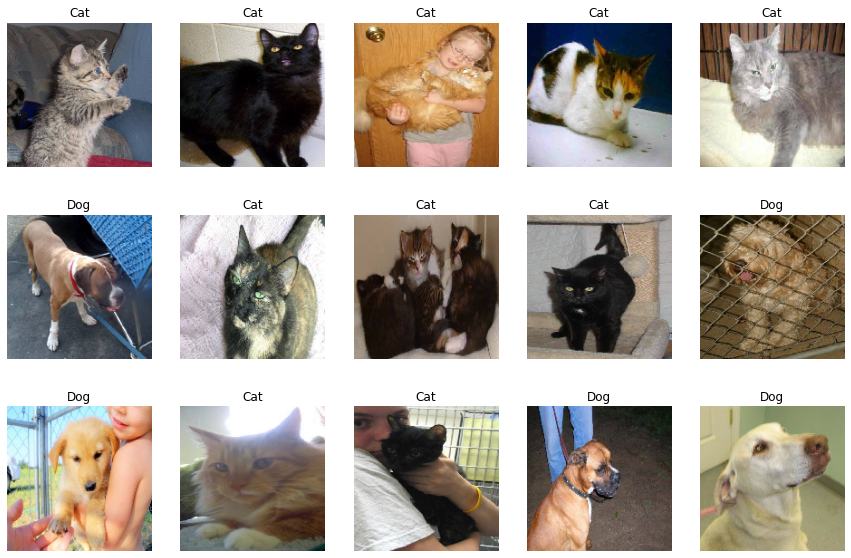

In [5]:
# Display a few images and labels

class_names = np.array(['Dog', 'Cat'])

plt.figure(figsize=(15,10))
inx = np.random.choice(images_train.shape[0], 15, replace=False)
for n, i in enumerate(inx):
    ax = plt.subplot(3,5,n+1)
    plt.imshow(images_train[i])
    plt.title(class_names[labels_train[i]])
    plt.axis('off')

#### Create a benchmark model

We will first train a CNN classifier model as a benchmark model before implementing the transfer learning approach. Using the **functional API**, build the benchmark model according to the following specifications:

* The model should use the `input_shape` in the function argument to set the shape in the Input layer.
* The first and second hidden layers should be Conv2D layers with 32 filters, 3x3 kernel size and ReLU activation.
* The third hidden layer should be a MaxPooling2D layer with a 2x2 window size.
* The fourth and fifth hidden layers should be Conv2D layers with 64 filters, 3x3 kernel size and ReLU activation.
* The sixth hidden layer should be a MaxPooling2D layer with a 2x2 window size.
* The seventh and eighth hidden layers should be Conv2D layers with 128 filters, 3x3 kernel size and ReLU activation.
* The ninth hidden layer should be a MaxPooling2D layer with a 2x2 window size.
* This should be followed by a Flatten layer, and a Dense layer with 128 units and ReLU activation
* The final layer should be a Dense layer with a single neuron and sigmoid activation.
* All of the Conv2D layers should use `'SAME'` padding.

In total, the network should have 13 layers (including the `Input` layer).

The model should then be compiled with the RMSProp optimiser with learning rate 0.001, binary cross entropy loss and and binary accuracy metric.

In [29]:
from re import X
#### GRADED CELL ####

# Complete the following function. 
# Make sure to not change the function name or arguments.

def get_benchmark_model(input_shape):
    """
    This function should build and compile a CNN model according to the above specification,
    using the functional API. The function takes input_shape as an argument, which should be
    used to specify the shape in the Input layer.
    Your function should return the model.
    """
    inputs = tf.keras.Input(shape = input_shape)
    x1 = tf.keras.layers.Conv2D(32 , (3,3) ,padding="same",  activation = 'relu')(inputs)
    x2= tf.keras.layers.Conv2D(32 , (3,3) ,padding="same", activation = 'relu')(x1)
    x3 = tf.keras.layers.MaxPool2D(2,2)(x2)
    x4 = tf.keras.layers.Conv2D(32 , (3,3) ,padding="same", activation = 'relu')(x3)
    x5 = tf.keras.layers.Conv2D(32 , (3,3) ,padding="same", activation = 'relu')(x4)
    x6 = tf.keras.layers.MaxPool2D(2,2)(x5)
    x7 = tf.keras.layers.Conv2D(128 , (3,3) ,padding="same", activation = 'relu')(x6)
    x8 = tf.keras.layers.Conv2D(128 , (3,3) ,padding="same", activation = 'relu')(x7)
    x9 = tf.keras.layers.MaxPool2D(2,2)(x8)
    x9 = tf.keras.layers.Flatten()(x9)
    x10 = tf.keras.layers.Dense(128 , activation = 'relu')(x9)
    x10 = tf.keras.layers.Dense(1 , activation = 'sigmoid')(x10)
    
    model = tf.keras.Model(inputs= inputs,outputs = x10, name = "bench")
    model.compile( optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])
    return model




In [30]:
# Build and compile the benchmark model, and display the model summary

benchmark_model = get_benchmark_model(images_train[0].shape)
benchmark_model.summary()

Model: "bench"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 160, 160, 3)]     0         
                                                                 
 conv2d_50 (Conv2D)          (None, 160, 160, 32)      896       
                                                                 
 conv2d_51 (Conv2D)          (None, 160, 160, 32)      9248      
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 80, 80, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_52 (Conv2D)          (None, 80, 80, 32)        9248      
                                                                 
 conv2d_53 (Conv2D)          (None, 80, 80, 32)        9248      
                                                             

#### Train the CNN benchmark model

We will train the benchmark CNN model using an `EarlyStopping` callback. Feel free to increase the training time if you wish.

In [31]:
# Fit the benchmark model and save its training history

earlystopping = tf.keras.callbacks.EarlyStopping(patience=2)
history_benchmark = benchmark_model.fit(images_train, labels_train, epochs=10, batch_size=32,
                                        validation_data=(images_valid, labels_valid), 
                                        callbacks=[earlystopping])

Epoch 1/10
19/19 [==============================] - 84s 4s/step - loss: 4.9353 - binary_accuracy: 0.4750 - val_loss: 0.6910 - val_binary_accuracy: 0.5000
Epoch 2/10
19/19 [==============================] - 84s 4s/step - loss: 0.6918 - binary_accuracy: 0.5383 - val_loss: 0.6892 - val_binary_accuracy: 0.5033
Epoch 3/10
19/19 [==============================] - 87s 5s/step - loss: 0.6930 - binary_accuracy: 0.5317 - val_loss: 0.6847 - val_binary_accuracy: 0.5467
Epoch 4/10
19/19 [==============================] - 90s 5s/step - loss: 0.6749 - binary_accuracy: 0.5700 - val_loss: 0.7287 - val_binary_accuracy: 0.5000
Epoch 5/10
19/19 [==============================] - 84s 4s/step - loss: 0.7019 - binary_accuracy: 0.5700 - val_loss: 0.6857 - val_binary_accuracy: 0.5400


In [39]:
for key in history_benchmark.history.keys():
    print(key)


loss
binary_accuracy
val_loss
val_binary_accuracy


#### Plot the learning curves

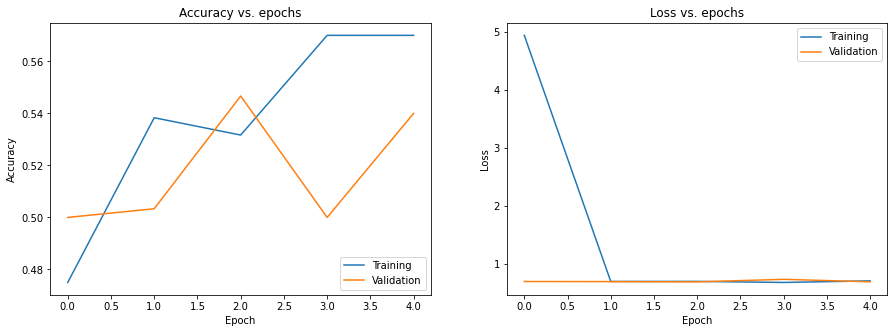

In [40]:
# Run this cell to plot accuracy vs epoch and loss vs epoch

plt.figure(figsize=(15,5))
plt.subplot(121)
try:
    plt.plot(history_benchmark.history['binary_accuracy'])
    plt.plot(history_benchmark.history['val_binary_accuracy'])
except KeyError:
    plt.plot(history_benchmark.history['binary_accuracy'])
    plt.plot(history_benchmark.history['val_binary_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')

plt.subplot(122)
plt.plot(history_benchmark.history['loss'])
plt.plot(history_benchmark.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

#### Evaluate the benchmark model

In [41]:
# Evaluate the benchmark model on the test set

benchmark_test_loss, benchmark_test_acc = benchmark_model.evaluate(images_test, labels_test, verbose=0)
print("Test loss: {}".format(benchmark_test_loss))
print("Test accuracy: {}".format(benchmark_test_acc))

Test loss: 0.6922555565834045
Test accuracy: 0.5166666507720947


#### Load the pretrained image classifier model

You will now begin to build our image classifier using transfer learning.
You will use the pre-trained MobileNet V2 model, available to download from [Keras Applications](https://keras.io/applications/#mobilenetv2). However, I have already downloaded the pretrained model for you, and it is attached with the assignment (the filename is `MobileNetV2.h5`).


If you are using Colab then you should store it in your Drive folder.

In [42]:
#### GRADED CELL ####

# Complete the following function. 
# Make sure to not change the function name or arguments.

def load_pretrained_MobileNetV2(path):
    """
    This function takes a path as an argument, and uses it to 
    load the full MobileNetV2 pretrained model from the path.
    Your function should return the loaded model.
    """
    model = tf.keras.models.load_model('/content/gdrive/MyDrive/CatVsDog/MobileNetV2.h5')
    return model


    
    

In [43]:
# Call the function loading the pretrained model, giving its path in your Drive folder, and display its summary

base_model = load_pretrained_MobileNetV2('path/to/MobileNetV2.h5')
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1_pad (ZeroPadding2D)      (None, 161, 161, 3)  0           ['input_6[0][0]']                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['Conv1_pad[0][0]']              
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]'

#### Use the pre-trained model as a feature extractor

You will remove the final layer of the network and replace it with new, untrained classifier layers for our task. 

You will first create a new model that has the same input tensor as the MobileNetV2 model (`pretrained_model` given as an argument), and uses the output tensor from the `pretrained_model` layer with name `global_average_pooling2d_6` as the model output.

You must use the **functional model API**

In [53]:
#### GRADED CELL ####

# Complete the following function. 
# Make sure to not change the function name or arguments.

def remove_head(pretrained_model):
    """
    This function takes a pretrained model as an argument.
    It should create and return a new model, using the input and output tensors as specified above. 
    Use the 'get_layer' method to access the correct layer of the pre-trained model.
    """
    model = tf.keras.Model(inputs=pretrained_model.input, 
                  outputs=pretrained_model.get_layer('global_average_pooling2d_6').output)
    return model
    

In [54]:
# Call the function removing the classification head and display the summary

feature_extractor = remove_head(base_model)
feature_extractor.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1_pad (ZeroPadding2D)      (None, 161, 161, 3)  0           ['input_6[0][0]']                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['Conv1_pad[0][0]']              
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']              

You can now construct new final classifier layers for your model. Using the **Sequential API**, create a new model according to the following specifications:

* The new model should begin with the feature extractor model.
* This should then be followed with a new dense layer with 32 units and ReLU activation function.
* This should be followed by a dropout layer with a rate of 0.5.
* Finally, this should be followed by a Dense layer with a single neuron and a sigmoid activation function.

In total, the network should be composed of the **pretrained base model plus 3 layers**.

In [57]:
#### GRADED CELL ####

# Complete the following function. 
# Make sure to not change the function name or arguments.

def add_new_classifier_head(feature_extractor_model):
    """
    This function takes the feature extractor model as an argument, and should create
    and return a new model according to the above specification.
    """
    model = Sequential( [feature_extractor_model,
                        tf.keras.layers.Dense(32, activation='relu'),
                        tf.keras.layers.Dropout(0.5),
                        tf.keras.layers.Dense(1, activation='sigmoid')
                        ])
    
    return model
    

In [58]:
# Call the function adding a new classification head and display the summary

new_model = add_new_classifier_head(feature_extractor)
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 1280)              2257984   
                                                                 
 dense_14 (Dense)            (None, 32)                40992     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_15 (Dense)            (None, 1)                 33        
                                                                 
Total params: 2,299,009
Trainable params: 2,264,897
Non-trainable params: 34,112
_________________________________________________________________


#### Freeze the weights of the pretrained model

You will now need to freeze the weights of the pre-trained feature extractor part of the `new_model` you just created, so that only the weights of the new layers you have added will change during the training. 

You should then compile your model as before: use the RMSProp optimiser with learning rate 0.001, binary cross entropy loss and and binary accuracy metric.

In [65]:
#### GRADED CELL ####

# Complete the following function. 
# Make sure to not change the function name or arguments.

def freeze_pretrained_weights(model):
    """
    This function takes the model specified above as an argument, and should freeze the 
    weights of the pre-trained feature extractor (defined as the first layer of the model).
    It should also compile the model as described above.
    Your function should return the model with the specified frozen weights.
    """
    model.layers[0].trainable = False
    model.compile( optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])    
    return model

In [66]:
# Call the function freezing the pretrained weights and display the summary

frozen_new_model = freeze_pretrained_weights(new_model)
frozen_new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 1280)              2257984   
                                                                 
 dense_14 (Dense)            (None, 32)                40992     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_15 (Dense)            (None, 1)                 33        
                                                                 
Total params: 2,299,009
Trainable params: 41,025
Non-trainable params: 2,257,984
_________________________________________________________________


#### Train the model

You are now ready to train the new model on the dogs vs cats data subset. We will use an `EarlyStopping` callback with patience set to 2 epochs, as before. Feel free to increase the training time if you wish.

In [67]:
# Train the model and save its training history

earlystopping = tf.keras.callbacks.EarlyStopping(patience=2)
history_frozen_new_model = frozen_new_model.fit(images_train, labels_train, epochs=10, batch_size=32,
                                                validation_data=(images_valid, labels_valid), 
                                                callbacks=[earlystopping])

Epoch 1/10
19/19 [==============================] - 26s 1s/step - loss: 0.3110 - binary_accuracy: 0.8633 - val_loss: 0.1634 - val_binary_accuracy: 0.9467
Epoch 2/10
19/19 [==============================] - 14s 744ms/step - loss: 0.1655 - binary_accuracy: 0.9317 - val_loss: 0.1156 - val_binary_accuracy: 0.9533
Epoch 3/10
19/19 [==============================] - 20s 1s/step - loss: 0.1120 - binary_accuracy: 0.9600 - val_loss: 0.1277 - val_binary_accuracy: 0.9600
Epoch 4/10
19/19 [==============================] - 14s 728ms/step - loss: 0.0764 - binary_accuracy: 0.9767 - val_loss: 0.1104 - val_binary_accuracy: 0.9533
Epoch 5/10
19/19 [==============================] - 13s 698ms/step - loss: 0.0651 - binary_accuracy: 0.9717 - val_loss: 0.1153 - val_binary_accuracy: 0.9467
Epoch 6/10
19/19 [==============================] - 13s 699ms/step - loss: 0.0459 - binary_accuracy: 0.9850 - val_loss: 0.1180 - val_binary_accuracy: 0.9500


#### Plot the learning curves

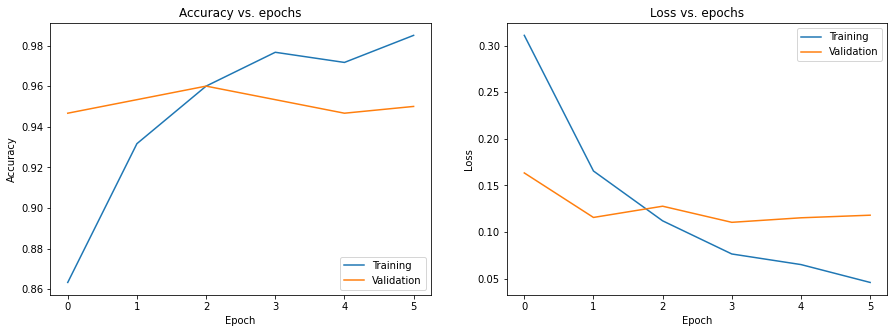

In [69]:
# Run this cell to plot accuracy vs epoch and loss vs epoch

plt.figure(figsize=(15,5))
plt.subplot(121)
try:
    plt.plot(history_frozen_new_model.history['binary_accuracy'])
    plt.plot(history_frozen_new_model.history['val_binary_accuracy'])
except KeyError:
    plt.plot(history_frozen_new_model.history['binary_accuracy'])
    plt.plot(history_frozen_new_model.history['val_binary_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')

plt.subplot(122)
plt.plot(history_frozen_new_model.history['loss'])
plt.plot(history_frozen_new_model.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

#### Evaluate the new model

In [70]:
# Evaluate the benchmark model on the test set

new_model_test_loss, new_model_test_acc = frozen_new_model.evaluate(images_test, labels_test, verbose=0)
print("Test loss: {}".format(new_model_test_loss))
print("Test accuracy: {}".format(new_model_test_acc))

Test loss: 0.08126918226480484
Test accuracy: 0.9733333587646484


#### Compare both models

Finally, we will look at the comparison of training, validation and test metrics between the benchmark and transfer learning model.

In [72]:
# Gather the benchmark and new model metrics

benchmark_train_loss = history_benchmark.history['loss'][-1]
benchmark_valid_loss = history_benchmark.history['val_loss'][-1]

try:
    benchmark_train_acc = history_benchmark.history['binary_accuracy'][-1]
    benchmark_valid_acc = history_benchmark.history['val_binary_accuracy'][-1]
except KeyError:
    benchmark_train_acc = history_benchmark.history['binary_accuracy'][-1]
    benchmark_valid_acc = history_benchmark.history['val_binary_accuracy'][-1]

new_model_train_loss = history_frozen_new_model.history['loss'][-1]
new_model_valid_loss = history_frozen_new_model.history['val_loss'][-1]

try:
    new_model_train_acc = history_frozen_new_model.history['binary_accuracy'][-1]
    new_model_valid_acc = history_frozen_new_model.history['val_binary_accuracy'][-1]
except KeyError:
    new_model_train_acc = history_frozen_new_model.history['binary_accuracy'][-1]
    new_model_valid_acc = history_frozen_new_model.history['val_binary_accuracy'][-1]

In [73]:
# Compile the metrics into a pandas DataFrame and display the table

comparison_table = pd.DataFrame([['Training loss', benchmark_train_loss, new_model_train_loss],
                                ['Training accuracy', benchmark_train_acc, new_model_train_acc],
                                ['Validation loss', benchmark_valid_loss, new_model_valid_loss],
                                ['Validation accuracy', benchmark_valid_acc, new_model_valid_acc],
                                ['Test loss', benchmark_test_loss, new_model_test_loss],
                                ['Test accuracy', benchmark_test_acc, new_model_test_acc]],
                               columns=['Metric', 'Benchmark CNN', 'Transfer learning CNN'])
comparison_table.index=['']*6
comparison_table

,Metric,Benchmark CNN,Transfer learning CNN
,Training loss,0.701882,0.045878
,Training accuracy,0.570000,0.985000
,Validation loss,0.685720,0.118045
,Validation accuracy,0.540000,0.950000
,Test loss,0.692256,0.081269
,Test accuracy,0.516667,0.973333


10/10 [==============================] - 5s 432ms/step


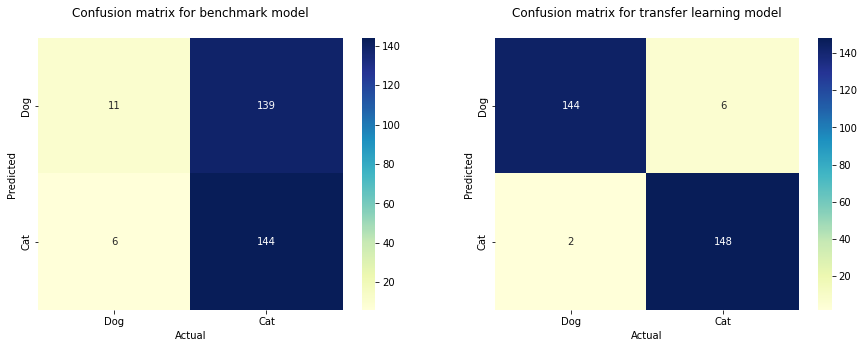

In [74]:
# Plot confusion matrices for benchmark and transfer learning models

plt.figure(figsize=(15, 5))

preds = benchmark_model.predict(images_test)
preds = (preds >= 0.5).astype(np.int32)
cm = confusion_matrix(labels_test, preds)
df_cm = pd.DataFrame(cm, index=['Dog', 'Cat'], columns=['Dog', 'Cat'])
plt.subplot(121)
plt.title("Confusion matrix for benchmark model\n")
sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
plt.ylabel("Predicted")
plt.xlabel("Actual")

preds = frozen_new_model.predict(images_test)
preds = (preds >= 0.5).astype(np.int32)
cm = confusion_matrix(labels_test, preds)
df_cm = pd.DataFrame(cm, index=['Dog', 'Cat'], columns=['Dog', 'Cat'])
plt.subplot(122)
plt.title("Confusion matrix for transfer learning model\n")
sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
plt.ylabel("Predicted")
plt.xlabel("Actual")
plt.show()